## Getting QuTip Down

In [1]:
import qutip as qt
import qutip.states as qts
import qutip.operators as qto
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sys
import seaborn as sns
from functools import reduce

sys.path.append("../dwaveutils/dwavetools")
sys.path.append("../dwaveutils/probrep")
from dictrep import DictRep
from dwavetools import (nqubit_1pauli, nqubit_2pauli, loadAandB, dict_to_qutip,
                       make_numeric_schedule, get_numeric_H, time_interpolation)

In [2]:
# Form a dictionary representation of a problem and create an anneal_schedule
dictparams = {(0, 0): 0.1, (1, 1): 0.1, (2, 2): 0.1, (0, 1): -0.1, (1, 2): -0.1, (0, 2): -0.1}
problem = DictRep(H = dictparams, qpu = 'dwave', vartype = 'ising', encoding = "logical")
schedule = make_numeric_schedule(.1, **{'ta': 10, 'sa': 0.5, 'tp': 10, 'tq':0.1})
times = schedule[0]
svals = schedule[1]

In [25]:
# Create H(t)
processor_data = loadAandB()
sch_ABfuncs = time_interpolation(schedule, processor_data)
Hs = get_numeric_H(problem)
A = sch_ABfuncs['A(t)']
B = sch_ABfuncs['B(t)']
HX = Hs['HX']
HZ = Hs['HZ']
# Define H(t)
H = lambda t : A(t)*HX + B(t)*HZ

# Define list_H for QuTiP
list_H = [[HX, A], [HZ, B]]

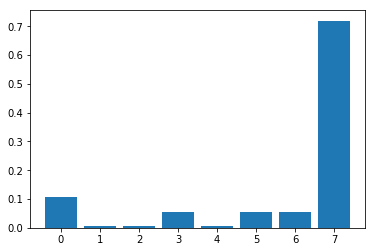

In [26]:
results = qt.sesolve(list_H, H(0).groundstate()[1], times)
amps = np.array([abs(results.states[-1][i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], amps.flatten())
plt.show()

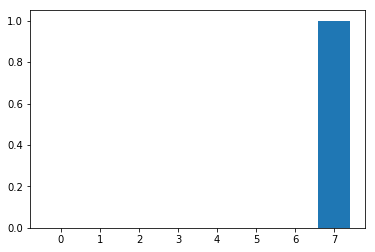

In [23]:
# exact diagonlization of ground-state at the end
gs = H(20).groundstate()[1]
gs_amps = np.array([abs(gs[i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], gs_amps.flatten())
plt.show()

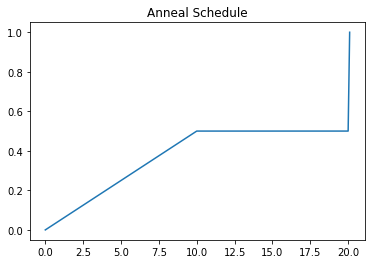

In [28]:
plt.plot(times, svals)
plt.title("Anneal Schedule")
plt.show()

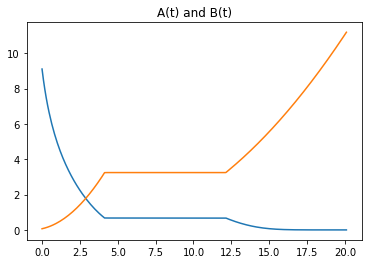

In [27]:
plt.plot(times, A(times))
plt.plot(times, B(times))
plt.title("A(t) and B(t)")
plt.show()

In [17]:
def make_numeric_schedule(discretization, **kwargs):
    """
    Creates an anneal_schdule to be used for numerical calculatins with QuTip. 
    Returns times and svals associated with each time that [times, svals]
    that together define an anneal schedule.
    
    Inputs: 
    discretization: determines what step size to use between points
    kwargs: dictionary that contains optional key-value args
    optional args: sa, ta, tp, tq
        sa: s value to anneal to 
        ta: time it takes to anneal to sa
        tp: time to pause after reaching sa
        tq: time to quench from sa to s = 1
    """
    # Parse the kwargs input which encodes anneal schedule parameters
    try:
        ta = kwargs['ta']
    except KeyError:
        raise KeyError("An anneal schedule must at least include an anneal time, 'ta'")
    
    # extracts anneal parameter if present; otherwise, returns an empty string
    direction = kwargs.get('direction', '')
    sa = kwargs.get('sa', '')
    tp = kwargs.get('tp', '')
    tq = kwargs.get('tq', '')
    
    # turn discretization into samplerate multiplier
    samplerate = 1 / discretization
    
    if direction == 'forward' or direction == '':
    
        # if no sa present, create a standard forward anneal for ta seconds
        if not sa:
            # determine slope of anneal
            sa = 1; ta = kwargs['ta'];
            ma = sa / ta

            # create a list of times with (ta+1)*samplerate elements
            t = np.linspace(0, ta, int((ta+1)*samplerate))

            # create linear s(t) function
            sfunc = ma*t

        # if no pause present, anneal forward for ta to sa then quench for tq to s=1
        elif not tp:
            # determine slopes and y-intercept (bq) to create piece-wise function
            ma = sa / ta
            mq = (1 - sa) / tq
            bq = (sa*(ta + tq) - ta)/tq

            # create a list of times where sampling for anneal/ quench proportional to time there
            t = reduce(np.union1d, (np.linspace(0, ta, int((ta+1)*samplerate)),
                                    np.linspace(ta+.00001, ta+tq, int((ta+tq+1)*samplerate))))

            # create a piece-wise-linear (PWL) s(t) function defined over t values
            sfunc = np.piecewise(t, [t <= ta, (ta < t) & (t <= ta+tq)],
                                [lambda t: ma*t, lambda t: bq + mq*t])

        # otherwise, forward anneal, pause, then quench
        else:
            # determine slopes and y-intercept (bq) to create piece-wise function 
            ma = sa / ta
            mp = 0
            mq = (1 - sa) / tq
            bq = (sa*(ta + tp + tq) - (ta + tp))/tq

            # create a list of times with samplerate elements from 0 and T = ta + tp + tq
            t = reduce(np.union1d, (np.linspace(0, ta, int((ta+1)*samplerate)),
                                    np.linspace(ta+.00001, ta+tp, int((ta+tp+1)*samplerate)),
                                    np.linspace(ta+tp+.00001, ta+tp+tq, int((ta+tp+tq+1)*samplerate))))

            # create a piece-wise-linear (PWL) s(t) function defined over t values
            sfunc = np.piecewise(t, [t <= ta, (ta < t) & (t <= ta+tp),(ta+tp < t) & (t <= ta+tp+tq)],
                                 [lambda t: ma*t, lambda t: sa, lambda t: bq + mq*t])
            
    elif direction == 'reverse':
        # if no pause, do standard 'reverse' anneal
        if not tp:
            # determine slopes and y-intercept (bq) to create piece-wise function
            ma = (sa - 1) / ta
            ba = 1
            mq = (1 - sa) / tq
            bq = (sa*(ta + tq) - ta)/tq

            # create a list of times where sampling for anneal/ quench proportional to time there
            t = reduce(np.union1d, (np.linspace(0, ta, int((ta+1)*samplerate)),
                                    np.linspace(ta+.00001, ta+tq, int((ta+tq+1)*samplerate))))

            # create a piece-wise-linear (PWL) s(t) function defined over t values
            sfunc = np.piecewise(t, [t <= ta, (ta < t) & (t <= ta+tq)],
                                [lambda t: ba + ma*t, lambda t: bq + mq*t])
            
        # otherwise, include pause
        else:
            # determine slopes and y-intercept (bq) to create piece-wise function 
            ma = (sa - 1) / ta
            ba = 1
            mp = 0
            mq = (1 - sa) / tq
            bq = (sa*(ta + tp + tq) - (ta + tp))/tq

            # create a list of times with samplerate elements from 0 and T = ta + tp + tq
            t = reduce(np.union1d, (np.linspace(0, ta, int((ta+1)*samplerate)),
                                    np.linspace(ta+.00001, ta+tp, int((ta+tp+1)*samplerate)),
                                    np.linspace(ta+tp+.00001, ta+tp+tq, int((ta+tp+tq+1)*samplerate))))

            # create a piece-wise-linear (PWL) s(t) function defined over t values
            sfunc = np.piecewise(t, [t <= ta, (ta < t) & (t <= ta+tp),(ta+tp < t) & (t <= ta+tp+tq)],
                                 [lambda t:ba + ma*t, lambda t: sa, lambda t: bq + mq*t])
            
        
        
    return [t, sfunc]


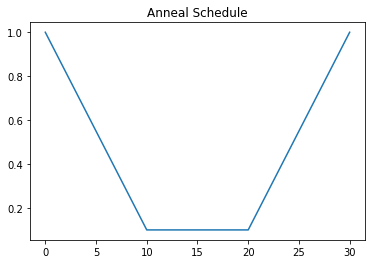

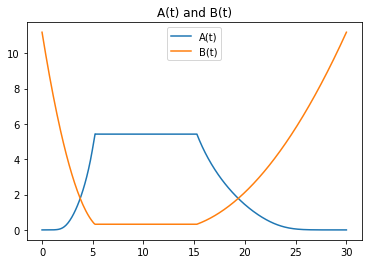

In [37]:
schedule = make_numeric_schedule(.1, **{'direction': 'reverse', 'ta': 10, 'tp': 10, 'sa': 0.1, 'tq':10})
times = schedule[0]
svals = schedule[1]
processor_data = loadAandB()
sch_ABfuncs = time_interpolation(schedule, processor_data)
Hs = get_numeric_H(problem)
A = sch_ABfuncs['A(t)']
B = sch_ABfuncs['B(t)']
plt.plot(times, svals)
plt.title("Anneal Schedule")
plt.show()
plt.plot(times, A(times), label="A(t)")
plt.plot(times, B(times), label="B(t)")
plt.title("A(t) and B(t)")
plt.legend()
plt.show()

In [23]:
HX = Hs['HX']
HZ = Hs['HZ']
# Define H(t)
H = lambda t : A(t)*HX + B(t)*HZ

# Define list_H for QuTiP
list_H = [[HX, A], [HZ, B]]

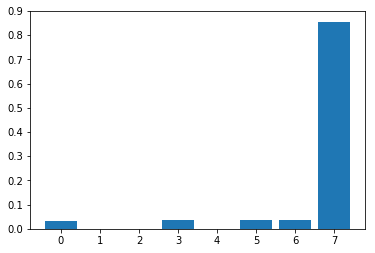

In [24]:
results = qt.sesolve(list_H, H(0).groundstate()[1], times)
amps = np.array([abs(results.states[-1][i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], amps.flatten())
plt.show()

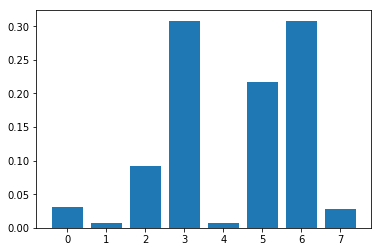

In [33]:
updownup = qts.ket([1, 0, 1])
results = qt.sesolve(list_H, updownup, times)
amps = np.array([abs(results.states[-1][i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], amps.flatten())
plt.show()

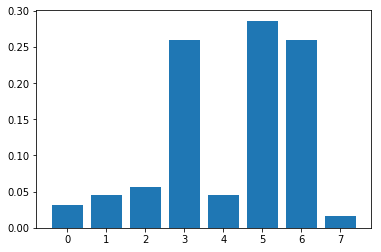

In [35]:
superposition = (5*qts.ket([1, 0, 1]) + 2*qts.ket([0, 1, 0])).unit()
results = qt.sesolve(list_H, superposition, times)
amps = np.array([abs(results.states[-1][i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], amps.flatten())
plt.show()